In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt

In [2]:
# https://www.kaggle.com/datasets/vetrirah/customer/data?select=Train.csv
# classification: customer segmentation
df = pd.read_csv('Train.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
print('data dimensions:',df.shape)
print('unique IDs:', df['ID'].nunique()) # IDs all unique, can be dropped
print(df['Segmentation'].value_counts()) # balanced y

data dimensions: (8068, 11)
unique IDs: 8068
Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64


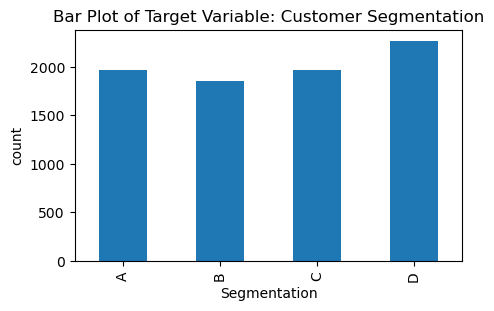

In [4]:
# ppt plot1
plt.figure(figsize=(5,3))
pd.value_counts(df['Segmentation']).loc[['A','B','C','D']].plot.bar()
plt.ylabel('count')
plt.xlabel('Segmentation')
plt.title('Bar Plot of Target Variable: Customer Segmentation')
plt.show()

Segmentation         A         B         C         D
Gender                                              
Female        0.248973  0.235826  0.252534  0.262668
Male          0.240661  0.225719  0.237265  0.296355


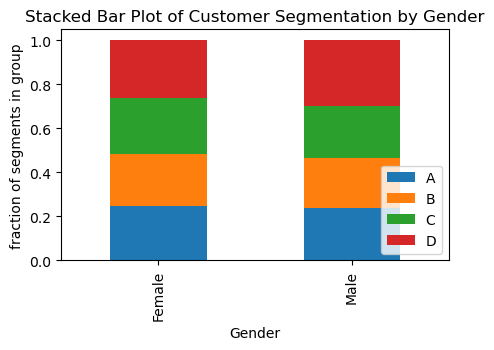

In [5]:
# ppt plot2
count_matrix = df.groupby(['Gender', 'Segmentation']).size().unstack()
# print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)

count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.ylabel('fraction of segments in group')
plt.legend(loc=4)
plt.title('Stacked Bar Plot of Customer Segmentation by Gender')
plt.show()

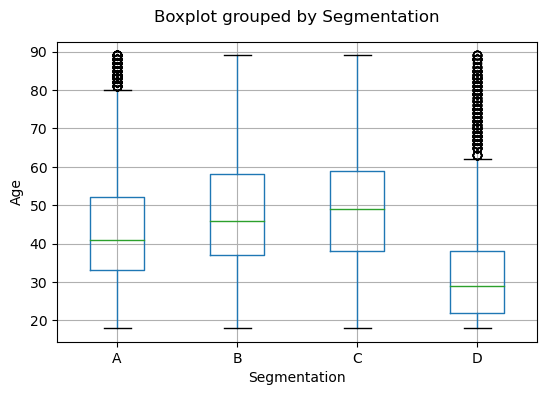

In [6]:
# ppt plot3
df[['Age','Segmentation']].boxplot(by='Segmentation',figsize=(6,4))
plt.ylabel('Age')
plt.xlabel('Segmentation')
plt.title('')
plt.show()

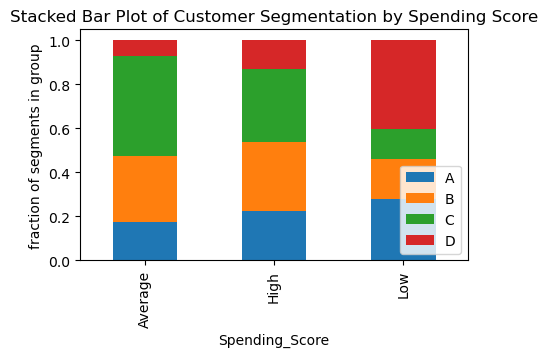

In [7]:
# ppt plot4
count_matrix = df.groupby(['Spending_Score', 'Segmentation']).size().unstack()
# print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)

count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.ylabel('fraction of segments in group')
plt.legend(loc=4)
plt.title('Stacked Bar Plot of Customer Segmentation by Spending Score')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

random_state = 0
X = df.drop(columns=['ID', 'Segmentation'])
y = df['Segmentation']
# training set
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state = random_state)
# validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state = random_state)

In [9]:
X_train.shape

(4840, 9)

In [10]:
print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('total number of features with missing values:', sum(perc_missing_per_ftr > 0))
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (8068, 11)
total number of features with missing values: 6
fraction of missing values in features:
Ever_Married       0.017353
Graduated          0.009668
Profession         0.015369
Work_Experience    0.102752
Family_Size        0.041522
Var_1              0.009420
dtype: float64
fraction of points with missing values: 0.1738968765493307


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

cat_ftrs = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']
ordinal_ftrs = ['Spending_Score']
ordinal_cats = [['Low', 'Average', 'High']]
num_ftrs = ['Age', 'Work_Experience', 'Family_Size']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [12]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# the feature names after fit
feature_names = preprocessor.get_feature_names_out()

# convert the numpy array back to a data frame with the feature names
df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the val
df_val = preprocessor.transform(X_val)
df_val = pd.DataFrame(data=df_val,columns = feature_names)
print(df_val.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)
print(feature_names)

(4840, 30)
(1614, 30)
(1614, 30)
['num__Age' 'num__Work_Experience' 'num__Family_Size' 'cat__Gender_Female'
 'cat__Gender_Male' 'cat__Ever_Married_No' 'cat__Ever_Married_Yes'
 'cat__Ever_Married_missing' 'cat__Graduated_No' 'cat__Graduated_Yes'
 'cat__Graduated_missing' 'cat__Profession_Artist'
 'cat__Profession_Doctor' 'cat__Profession_Engineer'
 'cat__Profession_Entertainment' 'cat__Profession_Executive'
 'cat__Profession_Healthcare' 'cat__Profession_Homemaker'
 'cat__Profession_Lawyer' 'cat__Profession_Marketing'
 'cat__Profession_missing' 'cat__Var_1_Cat_1' 'cat__Var_1_Cat_2'
 'cat__Var_1_Cat_3' 'cat__Var_1_Cat_4' 'cat__Var_1_Cat_5'
 'cat__Var_1_Cat_6' 'cat__Var_1_Cat_7' 'cat__Var_1_missing'
 'ord__Spending_Score']


/opt/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
# numerical missing values
print('data dimensions:',df_train.shape)
perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df_train[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (4840, 30)
fraction of missing values in features:
num__Work_Experience    0.101860
num__Family_Size        0.043802
dtype: float64
data types of the features with missing values:
num__Work_Experience    float64
num__Family_Size        float64
dtype: object
fraction of points with missing values: 0.13677685950413224
